## 0.Prepare the environment

In [1]:
!pip install -r requirments.txt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.5/863.5 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 

In [40]:
import pandas as pd
import json
import os
import re
# from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
import sys
sys.path.append('../..')
from rageval.models import OpenAILLM

## 1.Load test dataset

In [106]:
file_path = 'df_result_excel.xlsx'
df = pd.read_excel(file_path)
# qsts = df['question']
# evidences = [json.loads(i.replace("'", '"')) for i in df['evidences']]
# evidences = [[e['content'] for e in i] for i in evidences]
# qwen_results = df['qwen_results']
# yi_results = df['yi_results']
# glm4_results = df['glm4_results']

In [7]:
df.head(2)

,question,evidences,result,qwen_results,yi_results,glm4_results
0,1.习近平主席在何时何地会见了埃塞俄比亚总理海尔马里亚姆？,"[{'title': '习语录_1_list.json', 'content': '蒙方高度...",习近平主席在2017年5月12日于北京人民大会堂会见了来华出席“一带一路”国际合作高峰论坛的...,习近平主席在2017年5月12日于北京人民大会堂会见了埃塞俄比亚总理海尔马里亚姆。,习近平主席在2023年10月17日上午在北京人民大会堂会见了埃塞俄比亚总理阿比。[8] 请...,\n习近平主席分别于2017年5月12日在北京人民大会堂以及2023年3月28日在南非德班会...
1,2.埃塞俄比亚希望与中国在哪些领域加强合作？,"[{'title': '习语录_3_list.json', 'content': '贾格纳特...",根据所提供的支撑信息，埃塞俄比亚希望与中国在以下领域加强合作：\n\n1. **全面深化各领...,埃塞俄比亚希望与中国在以下领域加强合作：\n\n1. **共建“一带一路”框架下合作**：...,埃塞俄比亚希望与中国在以下领域加强合作：\n\n1. 政治合作： 埃塞俄比亚希望与中国保持...,\n埃塞俄比亚希望与中国在以下领域加强合作：\n\n1. 经贸和投资合作\n2. “一带一路...


## 2.LLM evaluator

Below we will use `ragas.OpenAILLM` to construct a LLM evaluator.

### 2.1 Deploy the model with vllm as a server

Run bash code to deploy `QwenQwen2-72B-Instruct` as a local LLM server, or you can deploy your own model. This model will evaluate the outputs we loaded before.
```bash
python -m vllm.entrypoints.openai.api_server \
  --model /home/gomall/models/QwenQwen2-72B-Instruct \
  --tensor-parallel-size 4 \
  --dtype auto \
  --api-key sk-123456789 \
  --gpu-memory-utilization 0.8 \
  --port 5000
```

Set environment varibles for OpenAILLM

In [6]:
os.environ["MODEL"] = "/home/gomall/models/QwenQwen2-72B-Instruct"
os.environ["BASE_URL"] = "127.0.0.1:5000"
os.environ["API_KEY"] = "sk-123456789"

### 2.2 prompts

Prepare prompts for LLM evaluator

In [52]:
RELEVANCE_SYSTEM = """You are an evaluator tasked with assessing the relevance of an answer to a given question. Your goal is to analyze the provided question and answer, and assign a relevance score between 1 and 5, where:

1: The model is completely unrelated to the question.
2: The model has minimal relevance, addressing only a small aspect of the question.
3: The model is somewhat relevant, covering some parts of the question but missing key elements.
4: The model is mostly relevant, addressing most aspects of the question with minor omissions.
5: The answer is highly relevant, thoroughly addressing the question with clear and comprehensive information.

Begin your evaluation by providing a short explanation. Be as objective as possible. After providing your explanation, please provide your evaluation by strictly following the format such as: [[3]]."""

CORRECTNESS_SYSTEM = """"Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. \
You will be given assistant A's answer and assistant B's answer. \
You should choose the assistant that follows the user's instructions and answers the user's questions better, consider the CORRECTNESS of answers\
Your job is to evaluate which assistant's answer is better, where:
A: if assistant A is better,
B: if assistant B is better,
C: for a tie.

Begin your evaluation by comparing the two responses and provide a short explanation. \
Identify and correct any mistakes. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. \
Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. \
After providing your explanation, output your final verdict by strictly following the format such as: [[A]]."""

QA = """[Question]
{question}

[The Start of Assistant’s Answer]
{answer_a}
[The End of Assistant’s Answer]"""

QA_PAIR = """[User Question]
{question}

[The Start of Assistant A's Answer]
{answer_a}
[The End of Assistant A's Answer]

[The Start of Assistant B's Answer]
{answer_b}
[The End of Assistant B's Answer]"""

In [53]:
def gen_prompt(question, answer_a, answer_b=None, reference=None, system_instruction=RELEVANCE_SYSTEM, user_instruction=QA):
    return [
            {"role": "system", "content": system_instruction.strip()},
            {"role": "user", "content": user_instruction.format(question=question, answer_a=answer_a, answer_b=answer_b, reference =reference)}
        ]

### 2.3 evaluate the model outputs

In [4]:
llm_evaluator = OpenAILLM(model=os.getenv("MODEL"), 
                          _api_key_env_var="API_KEY",
                          base_url=os.getenv("BASE_URL"))

The following `evaluate` function takes the entire dataframe `df` as input. 
- `answer_a` and `answer_b` are the column names of the data to be evaluated. 
- `sys_inst` and `usr_inst` are the prompt templates defined in section 2.2. 
- `max_workers` indicates the number of threads the LLM will use to process evaluation requests in parallel.

In [111]:
def evaluate(df:pd.DataFrame, answer_a:str, answer_b:str, sys_inst:str, usr_inst:str, max_workers:int):
    prompts = []
    for _, example in df.iterrows():
        prompts.append(gen_prompt(question=example['question'], 
                                  answer_a=example[answer_a], 
                                  answer_b=example[answer_b] if answer_b is not None else None, 
                                  reference=None, 
                                  system_instruction=sys_inst, 
                                  user_instruction=usr_inst))
    results = llm_evaluator.batch_generate(prompts, max_workers=max_workers)
    
    texts = [r.generations[0][0].text for r in results]
    
    def get_score(text:str):
        match = re.search(r'\[\[(\d|[A-Z])\]\]', text)
        return match.group(1) if match else None
    
    a = answer_a.split('_')[0]
    b = answer_b.split('_')[0] if answer_b is not None else None
    
    if answer_b is not None:
        df.loc[:, f"{a}_vs_{b}_completion"] = texts
        df.loc[:, f"{a}_vs_{b}_score"] = df[f"{a}_vs_{b}_completion"].apply(lambda x: get_score(x))
    else:
        df.loc[:, a + '_completion'] = texts
        df.loc[:, a + '_score'] = df[a + '_completion'].apply(lambda x: get_score(x))
    
    return prompts, df

In [108]:
original_results = ['yi_results', 'glm4_results', 'qwen_results']
# relevance
for answer_a in original_results:
    _, df = evaluate(df, answer_a=answer_a, answer_b=None, sys_inst=RELEVANCE_SYSTEM, usr_inst=QA, max_workers=8)

Generating:   0%|          | 0/45 [00:00<?, ?it/s]

Generating: 100%|██████████| 45/45 [00:16<00:00,  2.76it/s]


In [114]:
# correctness
import itertools
for (answer_a, answer_b) in itertools.combinations(original_results, 2):
    _, df = evaluate(df, answer_a=answer_a, answer_b=answer_b, sys_inst=CORRECTNESS_SYSTEM, usr_inst=QA_PAIR, max_workers=8)

Generating:   0%|          | 0/45 [00:00<?, ?it/s]

Generating: 100%|██████████| 45/45 [00:30<00:00,  1.49it/s]


In [118]:
# answer length 
for answer in original_results:
    df[f"{answer.split('_')[0]}_length"] = df[answer].apply(lambda x: len(x))

In [120]:
df.to_excel('df_relevance_correctness_length_excel.xlsx', index=False)

## 3.Result Analysis

In [190]:
models = ['yi','glm4','qwen']

results = pd.DataFrame({
    'relevance': [df[f"{m}_score"].astype(float).mean() for m in models],
    'answer_length': [df[f"{m}_length"].mean() for m in models],
},columns=['relevance','answer_length'], index=models)

results.T

,yi,glm4,qwen
relevance,4.733333,4.911111,4.933333
answer_length,2532.444444,311.466667,550.800000


### 3.1 calculate winrate for each pair

In [191]:
def calculate_winrates(df, models):
    wins = {k:0 for k in models}
    nums = {m:0 for m in models}
    for model_a, model_b in itertools.combinations(models, 2):
        a= df[f"{model_a}_vs_{model_b}_score"].to_list().count('A')
        b= df[f"{model_a}_vs_{model_b}_score"].to_list().count('B')
        c= df[f"{model_a}_vs_{model_b}_score"].to_list().count('C')
        wins[model_a] += a+0.5*c
        wins[model_b] += b+0.5*c
        nums[model_a] += a+b+c
        nums[model_b] += a+b+c
        # print(f"{model_a} vs {model_b}: ", wins[model_a], wins[model_b])
        
    return {k: wins[k]/nums[k] for k in models}

In [192]:
correctness_winrates = calculate_winrates(df, models)
results = pd.concat([results.T,pd.DataFrame([correctness_winrates], index=['correctness'])])

In [193]:
# normalize
results.loc['relevance'] = results.loc['relevance']/5
results.loc['answer_length'] = results.loc['answer_length']/results.loc['answer_length'].max()

In [194]:
results

,yi,glm4,qwen
relevance,0.946667,0.982222,0.986667
answer_length,1.000000,0.122991,0.217497
correctness,0.577778,0.377778,0.544444


### 3.2 Show results

In [200]:
import numpy as np
import matplotlib.pyplot as plt

def draw_radar(df):
    labels = df.index
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for c in df.columns:
        values = df[c].tolist()
        values += values[:1]
        ax.fill(angles, values, alpha=0.25, label=c)
        ax.plot(angles, values, linewidth=2)

    ax.set_yticks([i/5 for i in range(1, 5)])
    ax.set_yticklabels([str(i/5) for i in range(1, 5)])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()

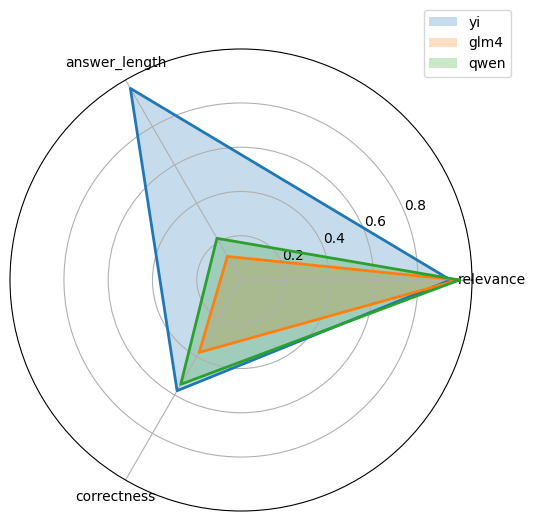

In [201]:
draw_radar(results)